In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import pycollocation

from energy_consumers import EnergyConsumer
from energy_markets import WholesaleEnergyMarket
from energy_sectors import RenewableEnergySector, NonRenewableEnergySector
from models import TransitionDynamicsModel

## Renewable Energy Sector

### Output

Assume that renewable energy sector takes capital and produces energy via some *decreasing returns to scale* production technology...

$$ E_R(t) = A_R K_R(t)^{\alpha_R} $$

...where $A_R > 0$ denotes technology (or total factor productivity) and $0 < \alpha_R < 1$ denotes the percentage change in renewable sector energy output from a 1% change in capital stock.

### Profits

Renewable energy sector profits at time $t$ are...

$$ \Pi_R(t) = S_R\big(p_E(t)\big) A_R K_R(t)^{\alpha_R} - p_K(t) I_R(t) $$

...where $S(p_E)$ denotes the subsidized price of energy and $p_K$ is the price of capital goods. Assume that representative firm in the renewable energy sector chooses the level of investment, $I_R(t)$, in order to maximize discounted lifetime profits...

$$ V\big(K_R(t)\big) = \max_{I_R(t)} \int_t^{\infty} e^{-r s}\bigg[S_R\big(p_E(s)\big) A_R K_R(s)^{\alpha_R} - p_K(s) I_R(s)\bigg] ds$$

...subject to the following constraint...

$$ \dot{K}_R(t) = I_R(t) - \delta_R K_R(t). $$

### Solution to profit maximization problem

To solve the above profit maximization problem, setup the *current value* Hamiltonian...

$$ H_R(t) = [S_R\big(p_E(t)\big) A_R K_R(t)^{\alpha_R} - p_K(t) I_R(t) + \lambda_R(t)\big[I_R(t) - \delta_R K_R(t)\big] $$

...first-order  optimality conditions are...

\begin{align}
    \frac{\partial H_R(t)}{\partial I_R(t)} = 0 \implies& -p_K(t) + \lambda_R(t) = 0 \\
    \frac{\partial H_R(t)}{\partial K_R(t)} = -\big[\dot{\lambda}_R(t) - r \lambda_R(t)\big] \implies& S_R\big(p_E(t)\big) A_R \alpha_R K_R(t)^{\alpha_R - 1} - \delta_R \lambda_R(t) = -\big[\dot{\lambda}_R(t) - r \lambda_R(t)\big] \\
\end{align}

#### Capital stock
Combining the above first-order conditions yields an equation for the stock of capital...

$$ K_R(t) = \bigg(\frac{S_R\big(p_E(t)\big)}{p_K(t)}\frac{A_R \alpha_R}{r + \delta_R - \frac{\dot{p}_K(t)}{p_K(t)}}\bigg)^{\frac{1}{1-\alpha_R}} $$

...note that this expression is decreasing in the price of capital, $p_K(t)$, the interest rate, $r$, and increasing in the subsidized energy price, $S_R\big(p_E(t)\big)$ and capital gains rate, $\frac{\dot{p}_K(t)}{p_K(t)}$.  In what follows we are assuming that the price of capital is *exogenous* and fixed (and therefore, we don't need to worry about capital gains!)...  

$$ K_R(t) = \bigg(\frac{S_R\big(p_E(t)\big)}{p_K}\frac{A_R \alpha_R}{r + \delta_R}\bigg)^{\frac{1}{1-\alpha_R}}. $$

#### Investment
How to determine the level of investment? Differentiate the equation for the stock of capital with respect to time, $t$...

$$ \dot{K}_R(t) = \frac{1}{1-\alpha_R}\bigg(\frac{S_R\big(p_E(t)\big)}{p_K}\frac{A_R \alpha_R}{r + \delta_R}\bigg)^{\frac{1}{1-\alpha_R}}\frac{\dot{S}_R\big(p_E(t)\big)}{S_R\big(p_E(t)\big)} = \frac{1}{1-\alpha_R}\frac{\dot{S}_R\big(p_E(t)\big)}{S_R\big(p_E(t)\big)} K_R(t)$$

...next, from the equation of motion for capital stock we have that...

$$ \frac{1}{1-\alpha_R}\frac{\dot{S}_R\big(p_E(t)\big)}{S_R\big(p_E(t)\big)} K_R(t) = I_R(t) - \delta_R K_R(t) $$

...which implies that the level of investment is proportional to capital stock...

$$ I_R(t) = \bigg(\frac{1}{1-\alpha_R}\frac{\dot{S}_R\big(p_E(t)\big)}{S_R\big(p_E(t)\big)} + \delta_R\bigg)K_R(t) $$


#### Renewable energy output

Substitute optimal capital demand back into the production function...

\begin{align}
    E_R(t) =& A_R K_R(t)^{\alpha_R} \\
    =& A_R^{\frac{1}{1-\alpha_R}}\bigg(\frac{S_R\big(p_E(t)\big)}{p_K}\frac{\alpha_R}{r + \delta_R}\bigg)^{\frac{\alpha_R}{1-\alpha_R}}
\end{align}

## Non-renewable energy sector

I based the following on lecture notes on [investment with adjustment costs](http://eml.berkeley.edu/~webfac/gourinchas/e202a_f14/Notes_Investment_pog.pdf) from UC Berkeley. Sector combines capital, $K_{NR}$, and fossil fuels, $F$, to produce energy $E_{NR}$ via...

$$ E_{NR}\big(F(t), K_{NR}(t)\big) = \bigg[\alpha K_{NR}(t)^{\rho} + \beta F(t)^{\rho}\bigg]^{\frac{\gamma}{\rho}} \tag{1} $$

...the above production function is a generalization of the constant elasticity of substitution (CES) family. Returns to scale are controled by the parameter $\gamma$ (i.e., $\gamma=1$ implies CRTS). Also note that this production function nests the standard Cobb-Douglas production function as a special (limiting!) case where $\gamma = \alpha + \beta, \rho=0$.

### Profits

Sector profits are...

$$ \Pi_{NR}(t) = p_E E_{NR}\big(F(t), K_{NR}(t)\big) - p_F F(t) - p_K\big(1 + C(I_{NR}, K_{NR})\big)I_{NR}(t) \tag{2} $$

...where $p_E$, $p_F$, and $p_K$ are, respectively, the prices of energy, fossil fuels, and capital goods; finally, $C(I_{NR}(t), K_{NR}(t))$ represents the *percentage* increase in costs required to install one unit of capital.  For sure we want to assume that $C_I > 0$ amd $C_{II} > 0$ (i.e., that adjustment costs are *convex* in the level of investment).  

Firm in the non-renewable energy sector solves...

$$ \max_{I_{NR}(t), F(t)} \int_t^{\infty} e^{-rs} \Pi_{NR}(s) ds \tag{4} $$

...subject to the following constraint...

$$ \dot{K}_{NR}(t) = I_{NR}(t) - \delta K_{NR}(t). \tag{5} $$

### Solution

Start by setting up the current value Hamiltonian...

$$ H(F(t), I(t), \lambda(t)) \equiv p_E(t) E\big(F(t), K_{NR}(t)\big) - p_F F(t) - p_K\bigg(1 + C\big(I_{NR}(t), K_{NR}(t)\big)\bigg)I_{NR}(t) + \lambda(t)\big[I_{NR}(t) - \delta K_{NR}(t)\big] \tag{6} $$ 

...first-order optimality conditions are...

\begin{align}
    \frac{\partial H}{\partial F} = 0 \implies& E_F\big(F(t), K_{NR}(t)\big) = \frac{p_F}{p_E(t)} \tag{7} \\
    \frac{\partial H}{\partial I} = 0 \implies& - p_K - p_K\bigg[C\big(I_{NR}(t), K_{NR}(t)\big) + C_I\big(I_{NR}(t), K_{NR}(t)\big)I_{NR}(t)\bigg] + \lambda(t) = 0 \\
    & 1 + C\big(I_{NR}(t), K_{NR}(t)\big) + C_I\big(I_{NR}(t), K_{NR}(t)\big)I_{NR}(t) = \frac{\lambda(t)}{p_K} \tag{8} \\
    \frac{\partial H}{\partial K} = -\big(\dot{\lambda}(t) - r\lambda(t)\big) \implies& p_E(t) E_K\big(F(t), K_{NR}(t)\big) - p_K C_K\big(I_{NR}(t), K_{NR}(t)\big)I_{NR}(t) - \delta\lambda(t) = -\big(\dot{\lambda}(t) - r\lambda(t)\big) \\
    &p_E(t) E_K\big(F(t), K_{NR}(t)\big) - p_KC_K\big(I_{NR}(t), K_{NR}(t)\big)I_{NR}(t) - \delta\lambda(t) = -\dot{\lambda}(t) + r\lambda(t) \\
    &(r + \delta)\frac{\lambda(t)}{p_K} + C_K\big(I_{NR}(t), K_{NR}(t)\big)I_{NR}(t) - \frac{p_E(t)}{p_K}E_K\big(F(t), K_{NR}(t)\big) = \frac{\dot{\lambda}(t)}{p_K} \tag{9}
\end{align}

...assumptions on functions $E\big(F(t), K_{NR}(t)\big)$ and $C\big(I(t), K_{NR}(t)\big)$ are sufficient to guarantee that there exist functions $\Phi$ and $\Psi$ such that equations 7 and 8 can be written as...

\begin{align}
    F(t) =& \Phi\big(K_{NR}(t), p_E(t)\big) \tag{10} \\
    I_{NR}(t) =& \Psi\bigg(\frac{\lambda(t)}{p_K}, K_{NR}(t)\bigg) \tag{11}
\end{align}

... substituting equations 10 and 11 into equation 9 and then defining Tobin's *marginal* $q$ as follows...

$$ q(t) = \frac{\lambda(t)}{p_K} \implies \dot{q}(t) = \frac{\dot{\lambda}(t)}{p_K} \tag{13}$$

...yields a differential equation describing the evolution of $q$...

$$ \dot{q}(t) = (r + \delta)q(t) + C_K\bigg(\Psi\big(q(t), K_{NR}(t)\big), K_{NR}(t)\bigg)\Psi\big(q(t), K_{NR}(t)\big) - \frac{p_E}{p_K}E_K\bigg(\Phi\big(K_{NR}(t), p_E(t)\big), K_{NR}(t)\bigg). \tag{14} $$

Need a differential equation describing the evolution of capital stock: just use the constraint!

\begin{align}
    \dot{K}_{NR}(t) =& I_{NR}(t) - \delta K_{NR}(t) \\
    =& \Psi\big(q(t), K_{NR}(t)\big) - \delta K_{NR}(t) \tag{15}
\end{align}

Equations 14 and 15 describe a system of differential equations describing the evolution of $K_{NR}(t)$ and $q(t)$.  To complete the model we need to define boundary conditions. Capital stock is predetermined so we take the initial condition as given: $K_{NR}(0) = K_0$.  Tobin's $q$ is a jump variable whose value is pinned down in steady state. Note the dependence on the wholesale price of energy $p_E(t)$.  To solve the model, we need to determine this price!

## Wholesale price for energy
Key endogenous variable in the model is the wholesale market price for energy, $p_E(t)$. Start by writing down the excess demand function for energy...

$$ XD\big(p_E(t)\big) \equiv AD\big(p_E(t)\big) - AS\big(p_E(t)\big) $$

...now the aggregate supply of energy is just the combined energy output from the non-renewable and renewable energy sectors...

$$ XD\big(p_E(t); K_{NR}(t)\big) \equiv AD\big(p_E(t)\big) - \Bigg[E_{NR}\bigg(K_{NR}(t), \Phi\big(K_{NR}(t), p_E(t)\big)\bigg) + A_R^{\frac{1}{1-\alpha_R}}\bigg(\frac{S_R\big(p_E(t)\big)}{p_K}\frac{\alpha_R}{r + \delta_R}\bigg)^{\frac{\alpha_R}{1-\alpha_R}}\Bigg] $$

...the market price of energy is then, then price that solves...

$$ 0 = AD\big(p_E(t)\big) - \Bigg[E_{NR}\bigg(K_{NR}(t), \Phi\big(K_{NR}(t), p_E(t)\big)\bigg) + A_R^{\frac{1}{1-\alpha_R}}\bigg(\frac{S_R\big(p_E(t)\big)}{p_K}\frac{\alpha_R}{r + \delta_R}\bigg)^{\frac{\alpha_R}{1-\alpha_R}}\Bigg]. $$

### Example: Fixed energy demand and Cobb-Douglas non-renewable energy production

Assume constant aggregate demand for energy from wholesalers...

$$ AD\big(p_E(t)\big) = \bar{D} $$

...aggregate supply is just the sum of energy produced in both non-renewable and renewable sectors...

$$ AS\big(p_E(t)\big) = A_{NR}^{\frac{1}{\alpha_{NR}}} \bigg((1 - 
\alpha_{NR}) \frac{p_E(t)}{p_F}\bigg)^{\frac{1-\alpha_{NR}}{\alpha_{NR}}} K_{NR}(t) + A_R^{\frac{1}{1-\alpha_R}}\bigg(\frac{S_R\big(p_E(t)\big)}{p_K}\frac{\alpha_R}{r + \delta_R}\bigg)^{\frac{\alpha_R}{1-\alpha_R}} $$

...define excess demand function as follows...

\begin{align}
    XD\big(p_E(t)\big) \equiv& AD\big(p_E(t)\big) - AS\big(p_E(t)\big) \\
    =& \bar{D} - A_{NR}^{\frac{1}{\alpha_{NR}}} \bigg((1 - \alpha_{NR}) \frac{p_E(t)}{p_F}\bigg)^{\frac{1-\alpha_{NR}}{\alpha_{NR}}} K_{NR}(t) - A_R^{\frac{1}{1-\alpha_R}}\bigg(\frac{S_R\big(p_E(t)\big)}{p_K}\frac{\alpha_R}{r + \delta_R}\bigg)^{\frac{\alpha_R}{1-\alpha_R}}
\end{align}

...the market price for energy is the price that solves $XD\big(p_E(t)\big) = 0$.

Suppose that $\alpha_R = 1 - \alpha_{NR} = \alpha$ and that $S_R\big(p_E(t)\big) = (1 + \mu_R)p_E(t)$...

\begin{align}
    XD\big(p_E(t)\big) =& \bar{D} - A_{NR}^{\frac{1}{1 - \alpha}} \bigg(\alpha \frac{p_E(t)}{p_F}\bigg)^{\frac{\alpha}{1 - \alpha}} K_{NR}(t) - A_R^{\frac{1}{1-\alpha}}\bigg((1 + \mu_R)\frac{p_E(t)}{p_K}\frac{\alpha}{r + \delta_R}\bigg)^{\frac{\alpha}{1-\alpha}} \\
    =& \bar{D} - \bigg[A_{NR}^{\frac{1}{1 - \alpha}} \bigg(\frac{1}{p_F}\bigg)^{\frac{\alpha}{1 - \alpha}} K_{NR}(t) + A_R^{\frac{1}{1-\alpha}}\bigg(\frac{1 + \mu_R}{p_K}\frac{1}{r + \delta_R}\bigg)^{\frac{\alpha}{1-\alpha}}\bigg]\big(\alpha p_E(t)\big)^{\frac{\alpha}{1-\alpha}}
\end{align}

...setting excess demand equal to zero, we can derive a closed form expression for the market price...

$$ p_E(t) = \frac{1}{\alpha}\left[\frac{\bar{D}}{A_{NR}^{\frac{1}{1 - \alpha}} \bigg(\frac{1}{p_F}\bigg)^{\frac{\alpha}{1 - \alpha}} K_{NR}(t) + A_R^{\frac{1}{1-\alpha}}\bigg(\frac{1 + \mu_R}{p_K}\frac{1}{r + \delta_R}\bigg)^{\frac{\alpha}{1-\alpha}}}\right]^{\frac{1 - \alpha}{\alpha}} $$

...note the the wholesale market price of energy is a *decreasing* function of non-renewable sector capital stock: this means that as the non-renewable sector energy production declines, the wholesale market price of energy will rise!

## Equilibrium
Equilibrim values of endogenous variables $q(t)$, $p_E(t)$ and $K_{NR}(t)$ solve the following system of equations...

\begin{align}
    0 =& XD\big(p_E\big) \\
    0 =& \Psi\big(q, K_{NR}\big) - \delta K_{NR} \\
    0 =& (r + \delta)q + C_K\bigg(\Psi\big(q, K_{NR}\big), K_{NR}\bigg)\Psi\big(q, K_{NR}\big) - \frac{p_E}{p_K}E_K\bigg(\Phi\big(K_{NR}, p_E\big), K_{NR}\bigg)
\end{align}

### Example
Suppose that adjustment costs are modeled as...

$$ C\big(I_{NR}, K_{NR}\big) = \frac{\phi}{2}\bigg(\frac{I_{NR}}{K_{NR}}\bigg)^2 $$

...and that the energy production in the non-renewable energy sector exhibts constant returns to scale with a Cobb-Douglas functional form...

$$E_{NR}(t) = A_{NR}K_{NR}(t)^{\alpha_{NR}}F(t)^{1-\alpha_{NR}}$$

...and that $\alpha_R =1 - \alpha_{NR}$.

Under these assumptions we have that...
\begin{align}
    I_{NR} = \Psi\big(q, K_{NR}\big) =& \bigg(\frac{1}{\phi}\frac{2}{3}\big(q - 1\big)\bigg)^{\frac{1}{2}}K_{NR} \\
    F = \Phi\big(K_{NR}, p_E\big) =& \bigg(A_{NR}(1 - \alpha_{NR})\frac{p_E}{p_F}\bigg)^{\frac{1}{\alpha_{NR}}}K_{NR} \\
    p_E =& \frac{1}{\alpha}\left[\frac{\bar{D}}{A_{NR}^{\frac{1}{1 - \alpha}} \bigg(\frac{1}{p_F}\bigg)^{\frac{\alpha}{1 - \alpha}} K_{NR} + A_R^{\frac{1}{1-\alpha}}\bigg(\frac{1 + \mu_R}{p_K}\frac{1}{r + \delta_R}\bigg)^{\frac{\alpha}{1-\alpha}}}\right]^{\frac{1 - \alpha}{\alpha}}
\end{align}

...which we can substitute into the above system to obtain...

\begin{align}
    p_E =& \frac{1}{\alpha}\left[\frac{\bar{D}}{A_{NR}^{\frac{1}{1 - \alpha}} \bigg(\frac{1}{p_F}\bigg)^{\frac{\alpha}{1 - \alpha}} K_{NR} + A_R^{\frac{1}{1-\alpha}}\bigg(\frac{1 + \mu_R}{p_K}\frac{1}{r + \delta_R}\bigg)^{\frac{\alpha}{1-\alpha}}}\right]^{\frac{1 - \alpha}{\alpha}} \\
    \big(\alpha p_E\big)^{\frac{\alpha}{1 - \alpha}} =& \frac{\bar{D}}{A_{NR}^{\frac{1}{1 - \alpha}} \bigg(\frac{1}{p_F}\bigg)^{\frac{\alpha}{1 - \alpha}} K_{NR} + A_R^{\frac{1}{1-\alpha}}\bigg(\frac{1 + \mu_R}{p_K}\frac{1}{r + \delta_R}\bigg)^{\frac{\alpha}{1-\alpha}}} \\
    A_{NR}^{\frac{1}{1 - \alpha}} \bigg(\frac{1}{p_F}\bigg)^{\frac{\alpha}{1 - \alpha}} K_{NR} + A_R^{\frac{1}{1-\alpha}}\bigg(\frac{1 + \mu_R}{p_K}\frac{1}{r + \delta_R}\bigg)^{\frac{\alpha}{1-\alpha}} =& \frac{\bar{D}}{\big(\alpha p_E\big)^{\frac{\alpha}{1 - \alpha}} } \\
    A_{NR}^{\frac{1}{1 - \alpha}} \bigg(\frac{1}{p_F}\bigg)^{\frac{\alpha}{1 - \alpha}} K_{NR} =& \frac{\bar{D}}{\big(\alpha p_E\big)^{\frac{\alpha}{1 - \alpha}}} - A_R^{\frac{1}{1-\alpha}}\bigg(\frac{1 + \mu_R}{p_K}\frac{1}{r + \delta_R}\bigg)^{\frac{\alpha}{1-\alpha}}  \\
    K_{NR} =& \frac{\bar{D}}{A_{NR}^{\frac{1}{1 - \alpha}}\big(\alpha \frac{p_E}{p_F}\big)^{\frac{\alpha}{1 - \alpha}}} - \bigg(\frac{A_R}{A_{NR}}\bigg)^{\frac{1}{1-\alpha}}\bigg(\frac{p_F}{p_K}\frac{1 + \mu_R}{r + \delta_R}\bigg)^{\frac{\alpha}{1-\alpha}}  \\
    %0 =& \bigg(\frac{1}{\phi}\frac{2}{3}\big(q - 1\big)\bigg)^{\frac{1}{2}}K_{NR} - \delta_{NR} K_{NR} \\
    %0 =& \bigg(\frac{1}{\phi}\frac{2}{3}\big(q - 1\big)\bigg)^{\frac{1}{2}} - \delta_{NR} \\
    q =& 1 + \frac{3}{2}\phi \delta_{NR}^2 \\
    %0 =& (r + \delta)q -\phi\delta_{NR}^3 - \frac{p_E}{p_K}A_{NR}\alpha_{NR}K_{NR}^{\alpha_{NR}-1}\bigg(\bigg(A_{NR}(1 - \alpha_{NR})\frac{p_E}{p_F}\bigg)^{\frac{1}{\alpha_{NR}}}K_{NR}\bigg)^{1-\alpha_{NR}} \\
    %0 =& (r + \delta)q -\phi\delta_{NR}^3 - \frac{p_E}{p_K}A_{NR}\alpha_{NR}\bigg(A_{NR}(1 - \alpha_{NR})\frac{p_E}{p_F}\bigg)^{\frac{1-\alpha_{NR}}{\alpha_{NR}}} \\
    %0 =& (r + \delta)q -\phi\delta_{NR}^3 - p_E^{\frac{1}{\alpha_{NR}}}\frac{1}{p_K}A_{NR}^{\frac{1}{\alpha_{NR}}}\alpha_{NR}\bigg((1 - \alpha_{NR})\frac{1}{p_F}\bigg)^{\frac{1-\alpha_{NR}}{\alpha_{NR}}} \\
    %0 =& (r + \delta)q -\phi\delta_{NR}^3 - \bigg(\frac{p_E}{p_F}\bigg)^{\frac{1}{\alpha_{NR}}}\frac{p_F}{p_K}A_{NR}^{\frac{1}{\alpha_{NR}}}\alpha_{NR}\big(1 - \alpha_{NR}\big)^{\frac{1-\alpha_{NR}}{\alpha_{NR}}} \\
    %\bigg(\frac{p_E}{p_F}\bigg)A_{NR}\big(1 - \alpha_{NR}\big)^{1-\alpha_{NR}} =& \bigg(\frac{p_K}{p_F}\frac{(r + \delta)q -\phi\delta_{NR}^3}{\alpha_{NR}}\bigg)^{\alpha_{NR}} \\
    %p_E =& \frac{1}{\big(1 - \alpha_{NR}\big)^{1-\alpha_{NR}}}\frac{p_F}{A_{NR}}\bigg(\frac{p_K}{p_F}\frac{(r + \delta)q -\phi\delta_{NR}^3}{\alpha_{NR}}\bigg)^{\alpha_{NR}} \\
    p_E =& \frac{1}{\alpha^{\alpha}}\frac{p_F}{A_{NR}}\bigg(\frac{p_K}{p_F}\frac{(r + \delta_{NR})q -\phi\delta_{NR}^3}{1-\alpha}\bigg)^{1-\alpha}
\end{align}

Note that it is not obvious that 

In [146]:
rng = np.random.RandomState()

In [164]:

np.random.beta?

In [165]:
renewable_sector_params = {'alpha': 0.33, 'delta': 0.05, 'tfp': 3.692, 'mu': 0.1}
renewable_sector = RenewableEnergySector(**renewable_sector_params)

non_renewable_sector_params = {'tfp': 1.0, 'alpha': 0.67, 'beta': 0.33, 'delta': 0.025,
                        'phi': 0.5, 'gamma': 1, 'sigma': 1}
non_renewable_sector = NonRenewableEnergySector(**non_renewable_sector_params)

consumer = EnergyConsumer(1)

In [166]:
market = WholesaleEnergyMarket(consumer, non_renewable_sector, renewable_sector)

In [169]:
equilibrium_energy_price(market, 2000.0, 0.75, 0.09)

65.563896169383

In [170]:
equilibrium_capital(market, 2000.0, 0.01, 0.09)

-0.0015688873679556847

In [171]:
model = TransitionDynamicsModel(market, 2000.0, 1.0, 0.09)

In [172]:
model._rhs(0.0, 1.5, 0.0)

ZeroDivisionError: float division by zero

In [121]:
model.equilibrium

array([ 1.0001875 ,  0.00508069])

In [95]:
model._rhs(0.0, 1.05, equilibrium_capital(market, 1.0, 0.5, 0.09))

SystemError: PyEval_EvalFrameEx returned a result with an error set

In [93]:
model.equilibrium

SystemError: PyEval_EvalFrameEx returned a result with an error set

In [63]:
locus = lambda K: model._q_dot(model._energy_market.non_renewable_sector.equilibrium_q, K, model._compute_energy_price(K))

In [64]:
locus(1e-20)

0.11488341091883329

In [75]:
locus(1e12)

ValueError: f(a) and f(b) must have different signs

In [20]:
model._compute_energy_price(1e0)

0.003997869727805923

In [106]:
ts, solution = model.solve(0, 150, 1e-3, 'vode', nsteps=1000, method="bdf")

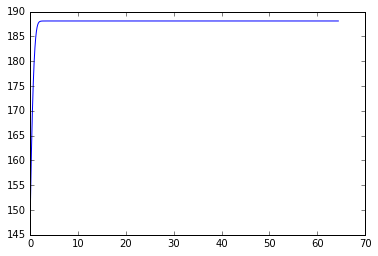

In [107]:
plt.plot(ts, solution[:, 1])

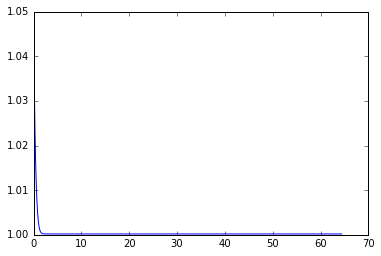

In [108]:
plt.plot(ts, solution[:, 0])

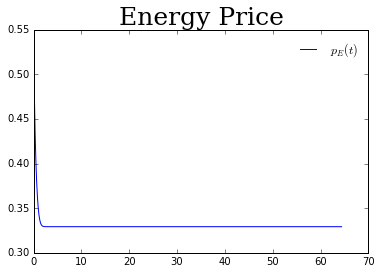

In [109]:
fig = model.plot_energy_price(ts, solution[:, 1])

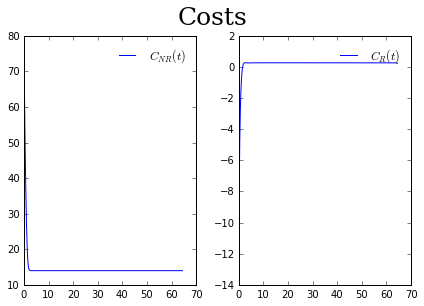

In [110]:
fig = model.plot_sector_costs(ts, solution[:, 0], solution[:, 1])

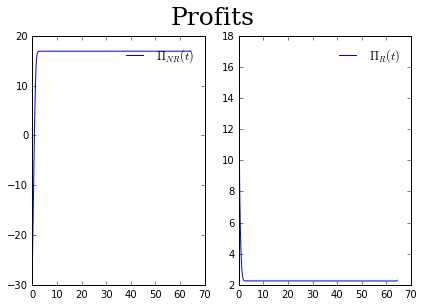

In [111]:
fig = model.plot_sector_profits(ts, solution[:, 0], solution[:, 1])

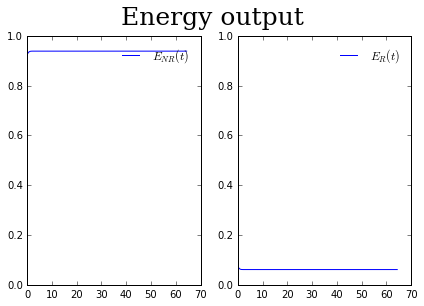

In [112]:
fig = model.plot_sector_energy_output(ts, solution[:, 0], solution[:, 1])

In [113]:
qs = np.linspace(1.0, 3, 100)
plt.plot([model.q_dot_locus(q) for q in qs], qs)
plt.axhline(1.0, color='k', linestyle='--')
equilibrium_q = model.equilibrium[0]
plt.plot(solution[:, 1], solution[:, 0])
plt.axhline(equilibrium_q, color='k')
#plt.xlim(3200, 3500)
plt.ylim(0.999, 1.1)
plt.show()

ValueError: f(a) and f(b) must have different signs

In [184]:
params = {'K0': 3000, 'interest_rate': 0.09, 'capital_price': 0.5, 'fossil_fuel_price': 0.75}

bvp = pycollocation.problems.TwoPointBVP(bcs_lower=initial_condition,
                                         bcs_upper=terminal_condition,
                                         number_bcs_lower=1,
                                         number_odes=2,
                                         params=params,
                                         rhs=model,
                                         )
    
polynomial_basis = pycollocation.basis_functions.PolynomialBasis()
solver = pycollocation.solvers.Solver(polynomial_basis)

boundary_points = (0, 100)
ts, qs, Ks = initial_mesh(*boundary_points, num=1000, problem=bvp)

basis_kwargs = {'kind': 'Chebyshev', 'domain': boundary_points, 'degree': 75}
K_poly = polynomial_basis.fit(ts, Ks, **basis_kwargs)
q_poly = polynomial_basis.fit(ts, qs, **basis_kwargs)
initial_coefs = np.hstack([q_poly.coef, K_poly.coef])
nodes = polynomial_basis.roots(**basis_kwargs)

solution = solver.solve(basis_kwargs, boundary_points, initial_coefs, nodes, bvp)

C:\Users\pughdr\Research\Transitions\energy_sectors.py:131: RuntimeWarning: invalid value encountered in sqrt
  demand = ((2 / 3) * (q - 1) * (1 / self._phi))**0.5 * capital


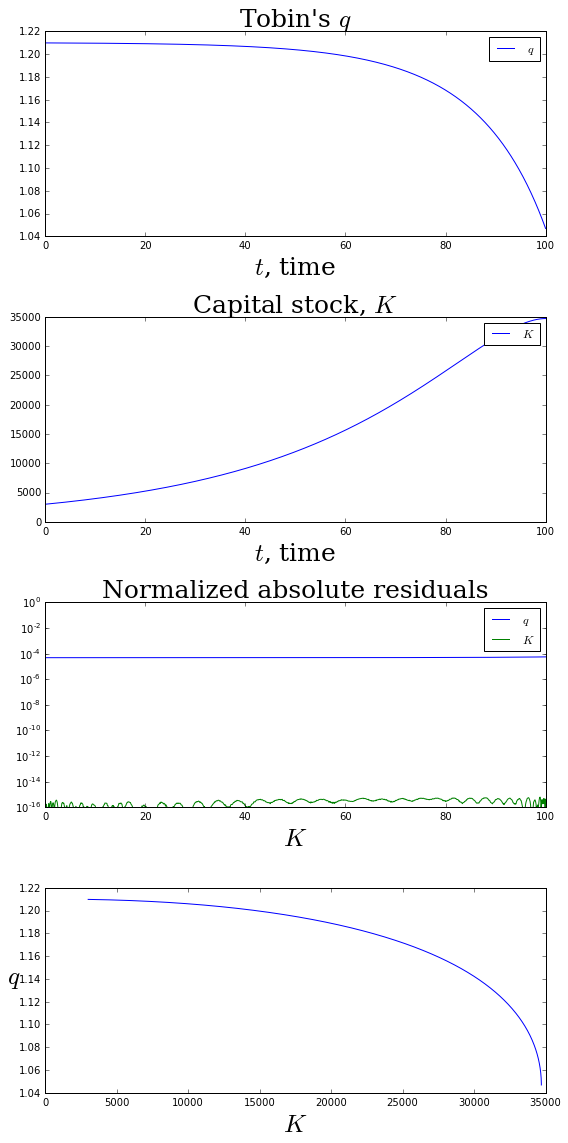

In [185]:
q_solution, capital_solution = solution.evaluate_solution(ts)

fig, axes = plt.subplots(4, 1, figsize=(8, 16))

axes[0].plot(ts, q_solution, label=r'$q$')
axes[0].set_xlabel(r'$t$, time', fontsize=25, family='serif')
axes[0].set_title(r"Tobin's $q$", fontsize=25, family='serif')
axes[0].legend()

axes[1].plot(ts, capital_solution, label=r'$K$')
axes[1].set_xlabel(r'$t$, time', fontsize=25, family='serif')
axes[1].set_title(r"Capital stock, $K$", fontsize=25, family='serif')
axes[1].legend()

# plot residuals
q_resids, capital_resids = solution.normalize_residuals(ts)

axes[2].plot(ts, np.abs(q_resids), label=r'$q$')
axes[2].plot(ts, np.abs(capital_resids), label=r'$K$')
axes[2].set_xlabel(r'$K$', fontsize=25)
axes[2].set_ylim(1e-16, 1.0)
axes[2].set_yscale('log')
axes[2].set_title("Normalized absolute residuals", fontsize=25, family='serif')
axes[2].legend()

axes[3].plot(capital_solution, q_solution)
axes[3].set_xlabel(r'$K$', fontsize=25)
axes[3].set_ylabel(r'$q$', fontsize=25, rotation='horizontal')

fig.tight_layout()

plt.show()


In [167]:
solution.result

    fjac: array([[ -3.32168219e-06,  -3.31699141e-06,  -3.33369993e-06, ...,
         -3.97008908e-01,   2.20816209e-08,   5.20953624e-05],
       [ -2.53957636e-05,  -2.52699206e-05,  -2.51882135e-05, ...,
          2.38072435e-01,   9.64184884e-08,  -3.14288677e-05],
       [ -5.44671316e-05,  -5.38379202e-05,  -5.28687824e-05, ...,
         -2.31227040e-01,   8.61262511e-08,   3.07338970e-05],
       ..., 
       [ -2.70108705e-02,   7.98221897e-02,  -1.29419844e-01, ...,
          1.69137478e-05,  -1.31230062e-07,   2.17928621e-04],
       [  1.08198559e-02,  -3.22690608e-02,   5.33557768e-02, ...,
          6.11248392e-06,   6.46368044e-08,   7.20022449e-05],
       [ -8.77331816e-03,   2.63629386e-02,  -4.41452778e-02, ...,
          6.90899961e-06,  -6.43853301e-08,   1.39091986e-04]])
     fun: array([  4.44342913e-14,   4.34426800e-14,   5.50204413e-14,
         6.66309456e-14,   7.15395625e-14,   7.04924400e-14,
         7.32710333e-14,   7.33113657e-14,   7.41125911e-14,
   